In [1]:
import numpy as np
import networkx as nx
import synthetic
from sharetrace import propagation, search
from matplotlib import pyplot as plt
import json
import pandas as pd

In [38]:
def group_stats(stats):
    groups = []
    it = iter(stats)
    while (stat := next(it, None)) is not None:
        if 'GraphSizeInMb' in stat:
            groups.append([stat])
        else:
            groups[-1].append(stat)
    return groups

def load_stats(name: str):
    with open(f'logs//{name}.log', 'r') as f:
        stats = [json.loads(line.split('|')[-1]) for line in f.readlines()]
        return group_stats(stats)
    
def split_stats(grouped):
    gstats = pd.DataFrame([g[0] for g in grouped])
    pstats = [pd.DataFrame(g[1:]) for g in grouped]
    return gstats, pstats

def get_runtime(pstats):
    return [p['RuntimeInSec'].max() for p in pstats]

def adj_mat(graph, n_nodes):
    adj = np.zeros((n_nodes,n_nodes))
    for (n1, n2) in (e for e in graph if isinstance(e, tuple)):
        adj[n1][n2] = 1
    return adj

In [65]:
data = synthetic.create_data(1000, high=0.3, low=-0.3)
scores = data.scores
hists = data.geohashes()
contacts = search.ContactSearch(min_dur=15, workers=-1).search(hists)

In [66]:
rp = propagation.RiskPropagation(tol=0.3, workers=4, timeout=3)
graph, _, labels = rp.create_graph(scores, contacts)
labels = np.array(labels)
adj = adj_mat(graph, rp._nodes)

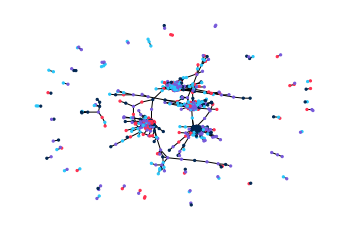

In [68]:
f = plt.figure()
network = nx.from_numpy_array(adj)
cidx = np.array(['#ff304f', '#002651', '#775ada', '#28c7fa'])
nx.draw(network, node_color=cidx[labels], node_size=5, ax=f.add_subplot(111))
# f.savefig('graph.png', dpi=300)

In [149]:
stats = load_stats(f'risk-propagation:ray')
_, pstats = split_stats(stats)
# runtime = get_runtime(pstats)

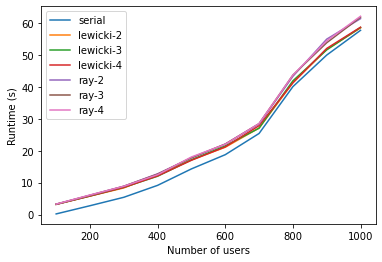

In [156]:
impls = ('serial', 'lewicki', 'ray')
pstarts = (0, 1, 2)
legend = ('serial', 'lewicki-2', 'lewicki-3', 'lewicki-4', 'ray-2', 'ray-3', 'ray-4')
for impl in impls:
    stats = load_stats(f'risk-propagation:{impl}')
    _, pstats = split_stats(stats)
    if impl == 'serial':
        runtime = get_runtime(pstats)
        runs = np.arange(1, len(runtime) + 1) * 100
        plt.plot(runs, runtime)
    else:
        for p in pstarts:
            plt.plot(runs, [pstats[i]['RuntimeInSec'].max() for i in range(p, 30, 3)])
plt.ylabel('Runtime (s)')
plt.xlabel('Number of users')
plt.legend(legend)
plt.savefig('runtime.png', dpi=300)